### **Практическое задание на тему суперкомпьютеров с использованием технологии MPI: Отчёт.**


#### **[Оконишников Арий Ариевич, 321 группа]**

Данный отчёт дополняет предыдущий, что находится в файле skipod_1.ipybn || skipod_1.pdf

В настоящей работе была реализована параллельная версия алгоритма вычисления определителя матрицы приведением к верхнетреугольному виду. Аналогично версии с OpenMP, сам алгоритм реализован в функции **double det(int N)**.

In [ ]:

double det(int N, int myrank, int ranksize)
{
	int i,j,k;
	double **A, tmp;
    A = (double**)malloc(sizeof(double*)*N);
    for(i = 0; i < N; i++) {
        A[i] = (double*)malloc(sizeof(double)*N);
    }
	srand(42);

	for (i = 0; i < N; i++ ) 
	{
		for (j = 0; j < N; j++ ) 
		{
			A[i][j] = (double)(rand()%10000)/((double)12000);
		}
	}

	double *L;
	L = (double*)malloc(sizeof(double)*N);
	for (i = 0; i < N; i++) 
	{ 	
		for (k = i; k < N; k++)
		{
			if (A[k][i] != 0)
			{
				for (j = 0; j < N; j++)
				{
					L[j] = A[k][j];
				}
				break;
			}
		}
		double *Weights;
		Weights = (double*)malloc(sizeof(double)*N);

		if (myrank==0)
		for (k = i+1; k < N; k++)
		{
			Weights[k] = A[k][i];
		}
		MPI_Bcast(&Weights[i+1], N-i-1, MPI_DOUBLE, 0, MPI_COMM_WORLD);

		for (k = myrank; k < N; k += ranksize)
		{
			if (k < i+1)
				continue;
			tmp = L[i] / Weights[k];
			if (A[k][i] != 0)
			{
				for (j = 0; j < N; j++) 
				{
					A[k][j] -= L[j] / tmp;
				}	
			}		
		}
		for (k = i+1; k < N; k++)
		{
			MPI_Bcast(&A[k][0], N, MPI_DOUBLE, k % ranksize, MPI_COMM_WORLD);
		}
	}

	double det=1;
	for (i = 0; i < N; i++) 
		det *= A[i][i];
	
	free(L);
	free(A);
	return det;
}

Функция получает на вход целое число N - размер матрицы, которая будет сгенерированна рандомно, но с учетом сида srand(42), а возвращает число - получившийся определитель.

Для каждого вызова функции высчитывается время нахождения управления внутри функции, т.е время выполнения. Она вызывается по три раза для каждого набора параметров, затем берется среднее из полученных отрезков времени для коррекциии возможных выбросов.

In [ ]:
int main(int argc, char **argv)
{
	int ranksize, myrank;

	MPI_Init(&argc, &argv);
	MPI_Comm_size(MPI_COMM_WORLD, &ranksize);
    MPI_Comm_rank(MPI_COMM_WORLD, &myrank);

	int i, j, k;
	int N[5] = {50, 100, 500, 1000, 2000};
	double start1, finish1, runing_t, res;

	for (i = 0; i < 5; i++) 
	{
		runing_t = 0;
		for (k = 0; k < 3; k++)
		{
			if (myrank == 0)
				start1 = MPI_Wtime();

			res = det(N[i], myrank, ranksize);

			if (myrank == 0)
			{
				finish1 = MPI_Wtime();
				runing_t += finish1-start1;
			}
		}
		if (myrank == 0)
			printf ("Size: %d, \t, Processes: %d, \tTime: %f s, \tResult: %f\n", N[i], ranksize, runing_t/((double)3), res);
	}
	MPI_Finalize();
}

Данная программа запускается **Processes** число раз - для каждого числа процессов - отдельно. Число процессов выбиралось как степень двойки.

Подсчёт времени происходит засчёт вызова функции **MPI_Wtime()**.

Полученные результаты, включая значение определятеля (для проверки на правильность выполнения) выводятся на машине **bluegene** в файлы типа mpi_determinant.XXXXXXXX.out, из которых затем формурется merged_data.txt. А затем формируется датасет для визуализации времени выполнения программы.

**merged_data.txt:**

      
      Size: 50,       , Processes: 2,         Time: 0.011707 s,       Result: 303.743470
      Size: 100,      , Processes: 2,         Time: 0.067955 s,       Result: 354814476506543168.000000
      Size: 500,      , Processes: 2,         Time: 5.939376 s,       Result: -111362502093081580696465357284349185141363634897860682081340490644453157477161850635769268008697701995163426412074897176298268911344098887448300193484020670589768438546239390998666552323643659310947053350472334322427970015973449055290417555491238851534389248.000000
      Size: 1000,     , Processes: 2,         Time: 43.659187 s,      Result: inf
      Size: 2000,     , Processes: 2,         Time: 333.218916 s,     Result: inf
      Size: 50,       , Processes: 4,         Time: 0.008479 s,       Result: 303.743470
      Size: 100,      , Processes: 4,         Time: 0.045922 s,       Result: 354814476506543168.000000
      Size: 500,      , Processes: 4,         Time: 3.331295 s,       Result: -111362502093081580696465357284349185141363634897860682081340490644453157477161850635769268008697701995163426412074897176298268911344098887448300193484020670589768438546239390998666552323643659310947053350472334322427970015973449055290417555491238851534389248.000000
      Size: 1000,     , Processes: 4,         Time: 24.790733 s,      Result: inf
      Size: 2000,     , Processes: 4,         Time: 196.285970 s,     Result: inf
      Size: 50,       , Processes: 8,         Time: 0.007674 s,       Result: 303.743470
      Size: 100,      , Processes: 8,         Time: 0.039481 s,       Result: 354814476506543168.000000
      Size: 500,      , Processes: 8,         Time: 2.444455 s,       Result: -111362502093081580696465357284349185141363634897860682081340490644453157477161850635769268008697701995163426412074897176298268911344098887448300193484020670589768438546239390998666552323643659310947053350472334322427970015973449055290417555491238851534389248.000000
      Size: 1000,     , Processes: 8,         Time: 17.629265 s,      Result: inf
      Size: 2000,     , Processes: 8,         Time: 138.709302 s,     Result: inf
      Size: 50,       , Processes: 16,        Time: 0.007603 s,       Result: 303.743470
      Size: 100,      , Processes: 16,        Time: 0.037693 s,       Result: 354814476506543168.000000
      Size: 500,      , Processes: 16,        Time: 2.021233 s,       Result: -111362502093081580696465357284349185141363634897860682081340490644453157477161850635769268008697701995163426412074897176298268911344098887448300193484020670589768438546239390998666552323643659310947053350472334322427970015973449055290417555491238851534389248.000000
      Size: 1000,     , Processes: 16,        Time: 14.134929 s,      Result: inf
      Size: 2000,     , Processes: 16,        Time: 110.395047 s,     Result: inf
      Size: 50,       , Processes: 32,        Time: 0.007437 s,       Result: 303.743470
      Size: 100,      , Processes: 32,        Time: 0.036070 s,       Result: 354814476506543168.000000
      Size: 500,      , Processes: 32,        Time: 1.794385 s,       Result: -111362502093081580696465357284349185141363634897860682081340490644453157477161850635769268008697701995163426412074897176298268911344098887448300193484020670589768438546239390998666552323643659310947053350472334322427970015973449055290417555491238851534389248.000000
      Size: 1000,     , Processes: 32,        Time: 12.368385 s,      Result: inf
      Size: 2000,     , Processes: 32,        Time: 96.064403 s,      Result: inf
      Size: 50,       , Processes: 64,        Time: 0.008449 s,       Result: 303.743470
      Size: 100,      , Processes: 64,        Time: 0.039738 s,       Result: 354814476506543168.000000
      Size: 500,      , Processes: 64,        Time: 1.765694 s,       Result: -111362502093081580696465357284349185141363634897860682081340490644453157477161850635769268008697701995163426412074897176298268911344098887448300193484020670589768438546239390998666552323643659310947053350472334322427970015973449055290417555491238851534389248.000000
      Size: 1000,     , Processes: 64,        Time: 11.843275 s,      Result: inf
      Size: 2000,     , Processes: 64,        Time: 91.722341 s,      Result: inf
      Size: 50,       , Processes: 128,       Time: 0.008399 s,       Result: 303.743470
      Size: 100,      , Processes: 128,       Time: 0.039257 s,       Result: 354814476506543168.000000
      Size: 500,      , Processes: 128,       Time: 1.707620 s,       Result: -111362502093081580696465357284349185141363634897860682081340490644453157477161850635769268008697701995163426412074897176298268911344098887448300193484020670589768438546239390998666552323643659310947053350472334322427970015973449055290417555491238851534389248.000000
      Size: 1000,     , Processes: 128,       Time: 11.371319 s,      Result: inf
      Size: 2000,     , Processes: 128,       Time: 88.314707 s,      Result: inf


In [17]:
data.tail(10)

,processes_Amount,Size,log_Time,real_Time
25,64,50,0.008414,0.008449
26,64,100,0.038969,0.039738
27,64,500,1.017292,1.765694
28,64,1000,2.552820,11.843275
29,64,2000,4.529609,91.722341
30,128,50,0.008364,0.008399
31,128,100,0.038506,0.039257
32,128,500,0.996070,1.707620
33,128,1000,2.515381,11.371319
34,128,2000,4.492166,88.314707


В колонке **log_Time** содержутся логарифмы от времени выполнения программы, когда в **real_Time** неизмененное время.

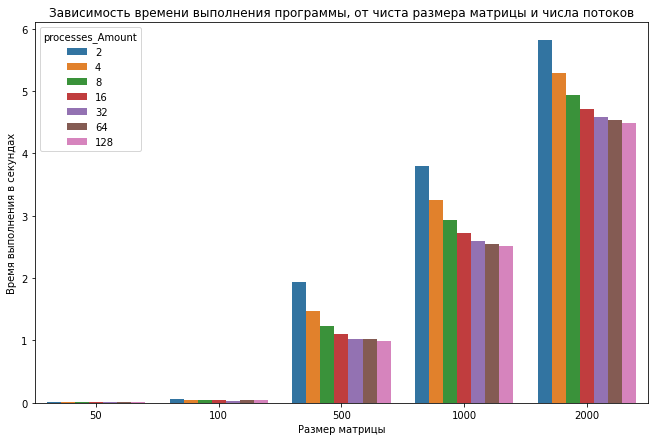

In [18]:
plt.figure(figsize=(11,7))
plt.title('Зависимость времени выполнения программы, от чиста размера матрицы и числа потоков')
sns.barplot(data=data, x="Size", hue="processes_Amount", y="log_Time")
plt.xlabel('Размер матрицы')
plt.ylabel('Логарифмическое время выполнения в секундах')

plt.show()

Проведем анализ полученных результатов. При увеличении числа процессов вовлеченных в работу, время выполнениея уменьшается. Однако заметим, что в целом время выполнения программы на MPI больше времени выполнения на OpenMP при том же размере матрицы. 

(Изобразить OpenMP и MPI на одном графике не очень корректно, так как OpenMP использует нити в качестве входного параметра, а MPI - процессы)

#### **Объясним, почему:**


OpenMP работает с тредами, в то время как MPI с процессами. Межпроцессорное взаимодействие порой вызывает немалые накладные расходы, и это как раз тот случай.

Алгоритм приведения матрицы к верхнетреугольному виду устроен так, что на каждой итерации внешнего цикла требуется обновлять N-i последних строк матрицы у всех процессов. Осуществляется это посредством **MPI_Bcast**, так как каждому процессу нужно передать данные всем остальным.

Выходит, что данной задаче OpenMP реализация подходит лучше.

#### **Проблемы недостаточной масштабируемости программы аналогичны по сравнению с OpenMP программой:**



Продублируем, что с каждой итерацией последнего блока for в тройном цикле, максимальное число процессов, которые могут быть задействованы в решении задачи уменьшается. Это естественно для поставленной задачи приведения матрицы к верхнетреугольному виду. На **m-ой** итерации цикла можно задействовать максимум **N-m-1** процессов (максимум, потому что в случае, если у матрицы много нулей на разных позициях, задействуем еще меньше потоков). **Выходит, с каждым задействованным процессом, всё меньше процессов будут работать эффективно.** Точно можно сказать, что использовать больше чем **N-1** потоков абсолютно бессмысленно и не даст увеличения по времени.

**Судя по полученным результатам** можем утверждать, что на больших данных использовать больше 64 процессов становиться экспоненциально невыгодно по времени, так как выигрыш незначителен.

Подводя итог, отметим, что для решаемой задачи, вопрос об оптимальном выборе числа процессов также зависит от двух факторов:
1. Важность загрузки всех процессоров
2. Важность прироста скорости

Исходя из этих двух причин мы выбираем число используемых процессов **1 <= processes_Amount <= N-1**.